In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import os
import scipy as scp
import scipy.signal as sgn

plt.style.use('fast')
#plt.rc('text', usetex=True)


In [20]:
filepaths = ['..\XRD']
measurements = {}
for filepath in filepaths:
    for name in os.listdir(filepath):
        if name.endswith('.xlsx'):
            df = pd.read_excel(filepath + '\\' + name)
            arr = np.transpose(df.to_numpy())
            measurements[name.split('.')[0]] = arr

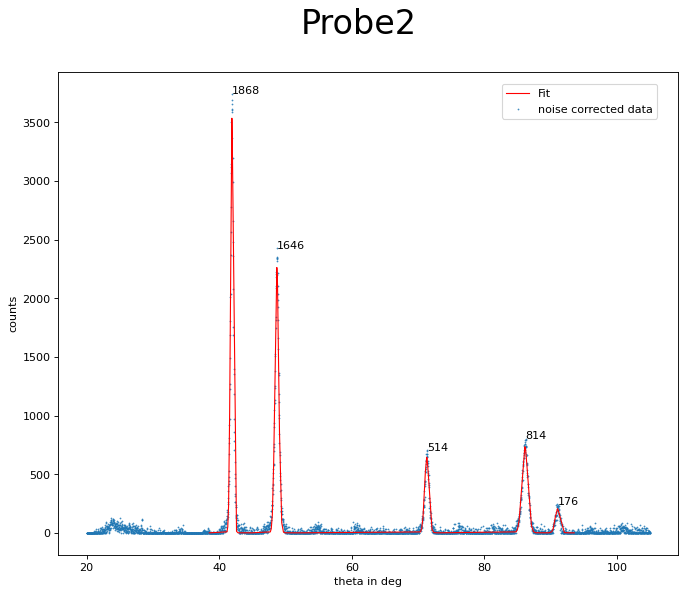

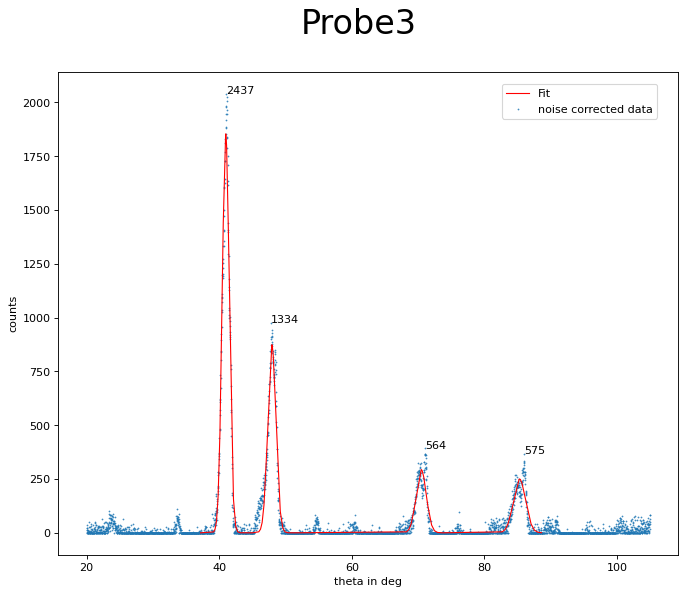

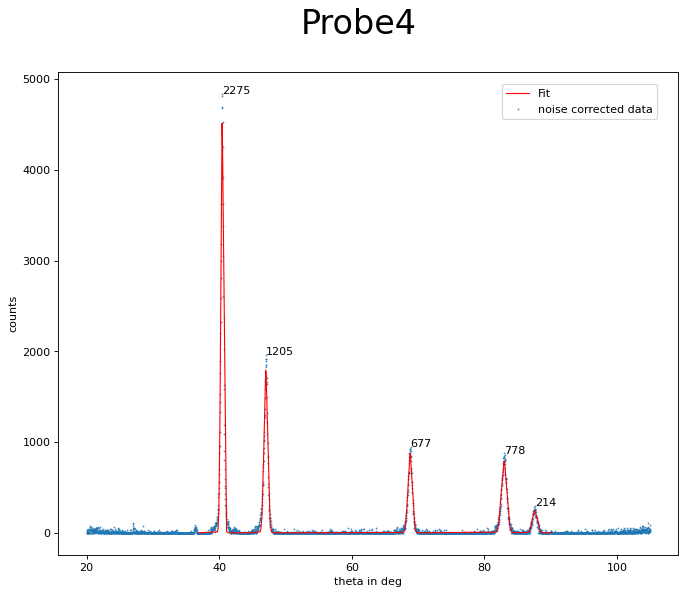

In [152]:
def f(x,a,b,c,d,e,f):
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5

def f2(x,a,b):
    return a + b*x

def clean(x,y):
    med = np.average(arr)
    x_n = []
    y_n = []
    for i,v in enumerate(y):
        if v < 3*med:
            x_n.append(x[i])
            y_n.append(v)
    return x_n,y_n

def clean2(x,y):
    med = np.average(arr)
    x_n = []
    y_n = []
    for i,v in enumerate(y):
        if v < 100:
            x_n.append(x[i])
            y_n.append(v)
    return x_n,y_n

def remove_noise(data,noise):
    clean = []
    for i,e in enumerate(data):
        if e > noise[i]:
            clean.append(e-noise[i])
        else:
            clean.append(0)
    return clean        


for name in measurements:
    intensity = measurements[name][-1]
    theta = measurements[name][0]

    fig = plt.figure(figsize=(10,8),dpi=80)
    fig.tight_layout(pad=0.5, w_pad=3.5, h_pad=3.5)
    fig.suptitle(name,size=30)
    
    ax = fig.add_subplot(111)
    #ax.scatter(theta,intensity,marker=".",s=1)
    #peaks, properties = sgn.find_peaks(intensity, prominence=10, width=20)
    #ax.scatter(theta[peaks],intensity[peaks],marker="o")

    x,y = clean(theta,intensity)
    popt, pcov = scp.optimize.curve_fit(f,x,y)
    intensity_new = remove_noise(intensity,[f(x,*popt) for x in theta])
    
    ax.scatter(theta,intensity_new,marker=".",s=1,label="noise corrected data")
    
    peaks, properties = sgn.find_peaks(intensity_new, prominence=1, width=15, distance=100)
    #ax.scatter(theta[peaks],[intensity_new[i] for i in peaks],marker="o")
    #ax.scatter(theta[properties['left_bases']],[0 for i in properties['left_bases']],color="green")
    #ax.scatter(theta[properties['right_bases']],[0 for i in properties['right_bases']],color="green")

    lbs = properties['left_bases'] - 100
    rbs = properties['right_bases'] + 100
    #ax.scatter(theta[lbs],[0 for i in lbs],color="red")
    #ax.scatter(theta[rbs],[0 for i in rbs],color="red")
    def gauss(x,A,w,xc):
        return 0 + A/(w*np.sqrt(np.pi/2)) *np.exp(-2*((x-xc)/w)**2)


    fit_x = []
    fit_y = []

    for i in range(len(rbs)):
        pop,pco = scp.optimize.curve_fit(gauss,theta[lbs[i]:rbs[i]],intensity_new[lbs[i]:rbs[i]],p0=[2*intensity_new[peaks[i]],4,theta[peaks[i]]])
        fit_x = np.concatenate((fit_x,theta[lbs[i]:rbs[i]]))
        fit_y = np.concatenate((fit_y,[gauss(x,*pop) for x in theta[lbs[i]:rbs[i]]]))
        #ax.plot(,[gauss(x,*pop) for x in theta[lbs[i]:rbs[i]]],color='red',linewidth=1)
        ingr = scp.integrate.quad(lambda x: gauss(x,*pop),theta[lbs[i]],theta[rbs[i]])
        ax.annotate(str(int(ingr[0])),(theta[peaks[i]],intensity_new[peaks[i]]))

    ax.plot(fit_x,fit_y,color='red',linewidth=1,label="Fit")
    ax.set(xlabel="theta in deg",ylabel="counts")
    fig.legend(loc=(0.72,0.8))


